In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from operator import attrgetter

warnings.filterwarnings("ignore")

## reading data

In [2]:
train = pd.read_csv('data/train.csv')
store = pd.read_csv('data/store.csv')
test = pd.read_csv('data/test.csv')

## Some plot functions

In [3]:
def remove_axes():
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

In [4]:
def barh_series(ser, col_name='', title='', show_count=True):
    plt.figure(figsize=(10, 0.6 * len(ser)))
    try:
        labels = ser.index.astype('int')
        if (ser.index != labels).any():
            labels = ser.index
    except:
        labels = ser.index
    plt.barh(labels, width=ser.values, tick_label=labels)
    if show_count:
        for label in labels:
            if ser[label] < max(ser) / 30:
                plt.text(max(ser) / 30, label, ser[label], color='black', fontsize='large', ha='left', va='center')
            else:
                plt.text(ser[label] / 2, label, ser[label], color='white', fontsize='large', ha='center', va='center')

    plt.title(title)
    plt.yticks(labels, labels)
    if show_count:
        plt.xticks([])
    remove_axes()
    plt.ylabel(col_name)
    plt.show()

In [5]:
def barh(df, col_name, show_count=True):
    barh_series(df[col_name].value_counts().sort_index(),
                col_name,
                f'{col_name} histogram',
                show_count)

In [6]:
def bar_series(ser, col_name='', title='', show_count=True, figsize=(10, 6), rotation=0):
    plt.figure(figsize=figsize)
    try:
        labels = ser.index.astype('int')
        if (ser.index != labels).any():
            labels = ser.index
    except:
        labels = ser.index
    plt.bar(labels, height=ser.values)
    plt.xticks(ticks=labels, labels=labels, rotation=rotation)
    if show_count:
        for label in labels:
            if ser[label] < max(ser) / 30:
                plt.text(label, max(ser) / 30, ser[label], color='black', fontsize='large', ha='center', va='bottom')
            else:
                plt.text(label, ser[label] / 2, ser[label], color='white', fontsize='large', ha='center', va='center')

    plt.title(title)
    plt.xlabel(col_name)
    plt.show()

In [7]:
def bar(df, col_name, show_count=True, figsize=(10, 6), rotation=0):
    bar_series(df[col_name].value_counts().sort_index(),
               col_name,
               f'{col_name} histogram',
               show_count,
               figsize,
               rotation)

In [8]:
def hist_series(ser, ser_name='', bins=60, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    plt.hist(ser, bins=bins)
    plt.xlabel(ser_name)
    plt.ylabel('count')
    plt.title(f'{ser_name} histogram')
    plt.show()

In [9]:
def hist(df, col_name, bins=60, figsize=(10, 6)):
    hist_series(df[col_name], col_name, bins, figsize)

# store

In [10]:
store.info()
store.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


The table contains 10 columns. It contains missing values.

The plot of missing values count:

In [11]:
na_counts = store.isna().sum()

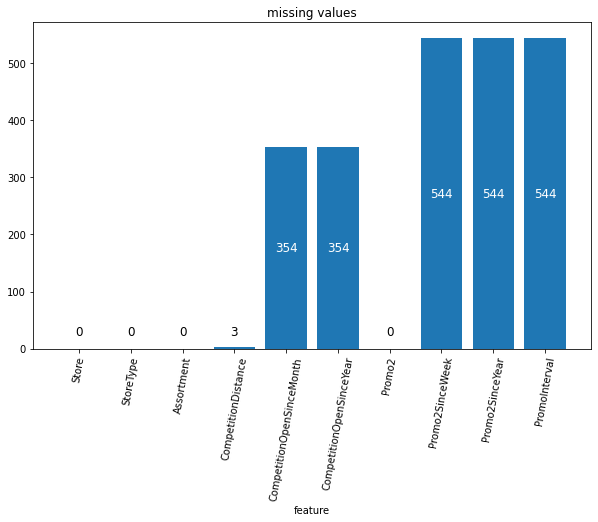

In [12]:
bar_series(title='missing values', ser=na_counts, col_name='feature', rotation=80)

## Store

The identifier of store. Ranges from 1 to 1115.

In [13]:
(pd.RangeIndex(1, 1116) == store.Store).all()

True

As it is the identifier of stores it will be removed when training the models.

## StoreType

The type of store. Its values are 'a', 'b', 'c' and 'd'. The histogram of values:

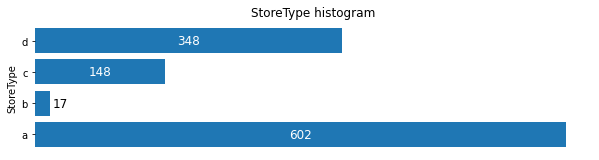

In [14]:
barh(store, 'StoreType')

This feature is categorical and its values are not numeric. So when training models it must be transformed to numeric features e.g. using one-hot encoder.

## Assortment

The type of assortment provided by the store. Its values are 'a', 'b' and 'c'. The histogram of values:

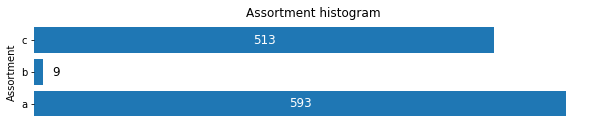

In [15]:
barh(store, 'Assortment')

This feature is also categorical and takes non-numeric values. So it must be transformed to numeric features e.g. using one-hot encoder.

## CompetitionDistance

The distance from the store to the nearest competitor store in meters. There are 3 (or 0.3%) missing values. The distribution of this feature:

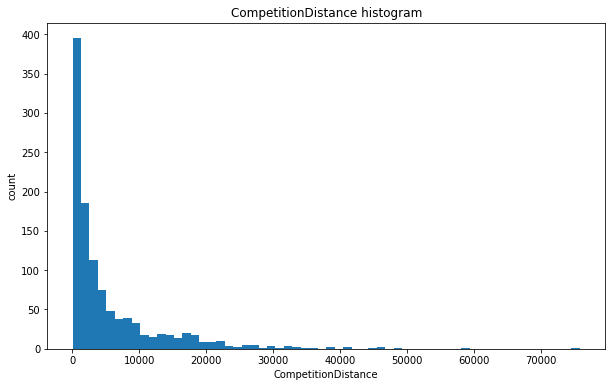

In [16]:
hist(store, 'CompetitionDistance')

This feature is numeric. Its distribution is similar to lognormal. Let's take a logarithm of this feature and show the distribution:

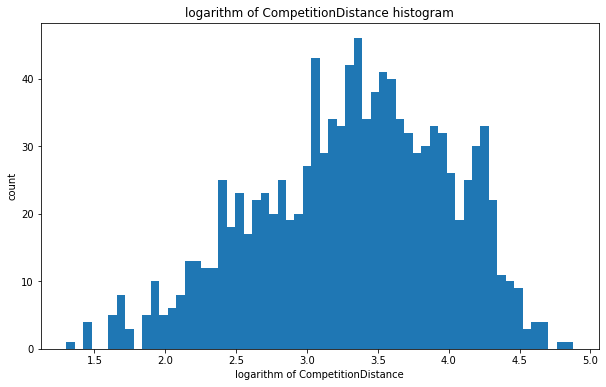

In [17]:
hist_series(np.log10(store.CompetitionDistance), 'logarithm of CompetitionDistance')

It is a bit similar to normal distribution. It is a good information for linear regression because it works better with such features.

The missing values can be replaced with mean value.

## CompetitionOpenSinceMonth

The month of the first opening of the nearest competitor store. There are 354 (or 31.7%) missing values. The distribution of this feature:

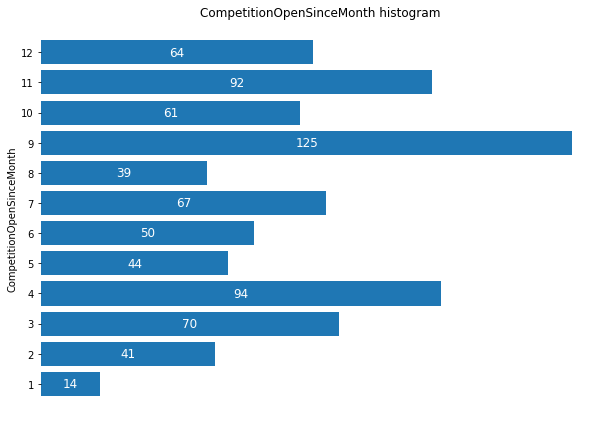

In [18]:
barh(store, 'CompetitionOpenSinceMonth')

This feature is categorical and takes numeric values. It can be transformed to numeric features e.g. using one-hot encoder. But there is a **CompetitionOpenSinceYear** feature. When describing it I will say how these 2 features can be combined.

## CompetitionOpenSinceYear

The year of the first opening of the nearest competitor store. There are 354 (or 31.7%) missing values. The distribution of this feature:

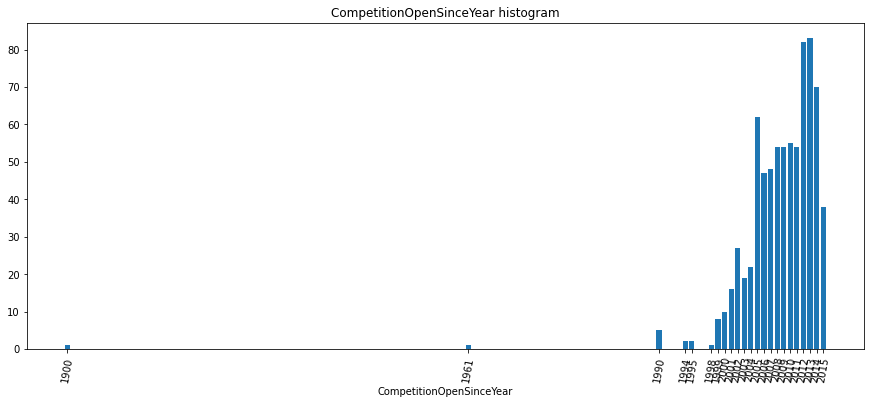

In [19]:
bar(store, 'CompetitionOpenSinceYear', show_count=False, figsize=(15, 6), rotation=80)

As you can see there are two outliers - 1900 and 1961. The distribution without them:

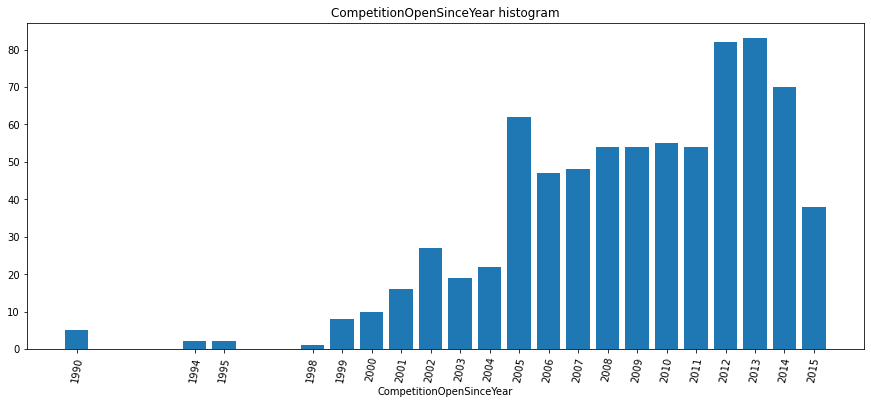

In [20]:
bar(store[~store.CompetitionOpenSinceYear.isin([1900, 1961])],
    'CompetitionOpenSinceYear',
    show_count=False, figsize=(15, 6), rotation=80)

So the most of competitor stores were opened during the last 15 years. The years 1900 and 1961 are the obvious outliers. They are errors because the Rossmann was founded in 1972. So these values must be changed e.g. to mean value or to the year of foundation.

This feature can be considered both as numeric and categorical. But it can be combined with the **CompetitionOpenSinceMonth** feature to **the ordered number of month from March, 1972** feature as the date of foundation of Rossmann is the 17-th of March, 1972. The new feature is numeric: it is greater for the older competitor stores.

There are 31.7 % of missing values for the last 2 features. As they are transformed to the new feature the missing values can be transformed for some outlier. For example -100.

## Promo2

Indicates whether the store is participating in promotion "Promo2" or not. Its values are 0 and 1. The histogram of values:

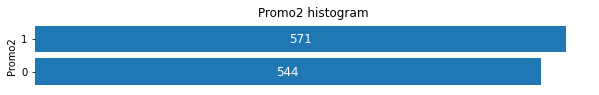

In [21]:
barh(store, 'Promo2')

This feature is categorical and takes only 2 distinct values - 0 and 1. So it is ready to be used in training.

## Promo2SinceWeek

The week of start of the participating in "Promo2". If Promo2 equals 0, this feature is missed. There are 544 missing values. The histogram of values:

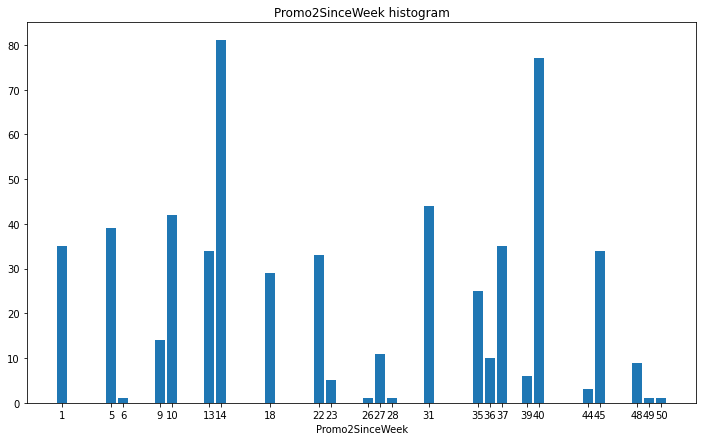

In [22]:
bar(store, 'Promo2SinceWeek', show_count=False, figsize=(12, 7))

This feature can be considered both as categorical and numeric. But the best way is to combine it with the **Promo2SinceYear** feature.

## Promo2SinceYear

The week of start of the participating in "Promo2". If Promo2 equals 0, this feature is missed. There are 544 missing values. The histogram of values:

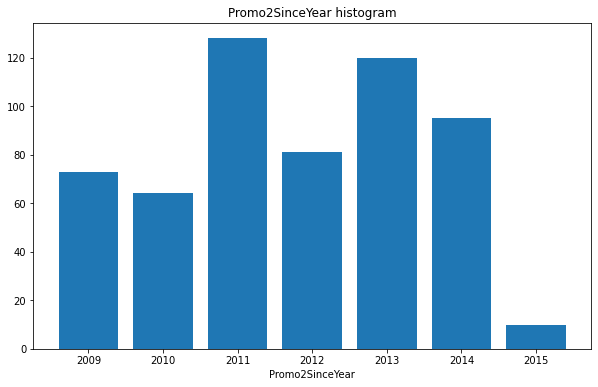

In [23]:
bar(store, 'Promo2SinceYear', show_count=False)

This feature can also be considered both as categorical and numeric. But let combine it with the **Promo2SinceWeek** to **the ordered number of week since the first one of 2009** feature. The new feature is numeric.

## PromoInterval

The consecutive intervals Promo2 is started, naming the months the promotion is started anew. If Promo2 equals 0, this feature is missed. There are 544 missing values. The histogram of values:

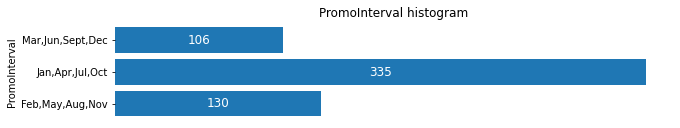

In [24]:
barh(store, 'PromoInterval')

This feature is categorical and takes non-numeric values. So it must be transformed to numeric features e.g. using one-hot encoder.

The last 3 features are missed iff the **Promo2** equals 0:

In [25]:
promo_na_counts = store[store.Promo2 == 1].isna().sum()

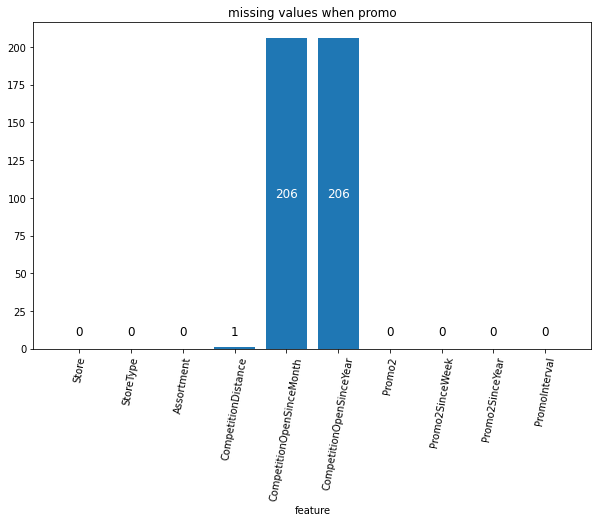

In [26]:
bar_series(title='missing values when promo', ser=promo_na_counts, col_name='feature', rotation=80)

So there is a problem how to fill missing values for these features. They can be filled by some outlier or other category. But I will do the following. I will divide the stores into 2 groups according to the **Promo2** value. For each group I will form its own train dataset and will train its own model. The new ***store*** table for group with **Promo2** equals 0 the features **Promo2**, **Promo2SinceWeek** and **Promo2SinceYear** will disappear. For group with **Promo2** equals 1 only the feature **Promo2** will disappear.

## Some relations between features

# train

In [27]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


There are no missing values. The table contains 9 columns.

## Store

The id of stores. It ranges from 1 to 1115.

In [28]:
(pd.RangeIndex(1, 1116) == train.Store.unique()).all()

True

## DayOfWeek

The weekday of the entry. It ranges from 1 to 7 and corresponds to names of week: 1 is monday, 2 is tuesday and so on.

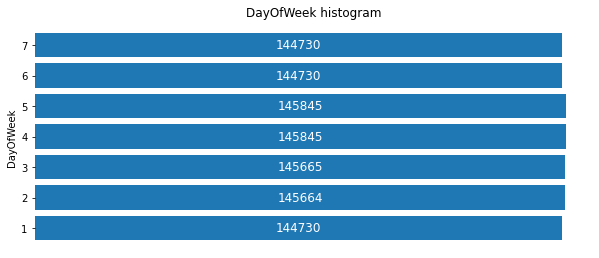

In [29]:
barh(train, 'DayOfWeek')

It is a categorical feature. It depends on **Date** feature. So its using also depends on using the **Date** feature. If all the table is splitted into time series for each store, then this feature most likely is unimportant. If only the lag features will be added, this feature will be useful.

## Date

The day of entry. In the table this feature is a string one. Let's research if there are all the days between the start and end.

In [30]:
dates = train.Date.apply(lambda date: datetime.datetime.strptime(date, '%Y-%m-%d'))
print('The number of unique dates:', dates.nunique())

The number of unique dates: 942


In [31]:
print('The start date in table:', dates.min())
print('The end date in table:', dates.max())
print('The number of different days between them:', (dates.max() - dates.min()).days + 1)

The start date in table: 2013-01-01 00:00:00
The end date in table: 2015-07-31 00:00:00
The number of different days between them: 942


So there are all the days between the start and end ones. As it is the feature that defines the time moment it is possible to split the table into time series for each store.

## Open

Indicates whether the store is opened at this day (equals 1) or closed (equals 0). The number of values:

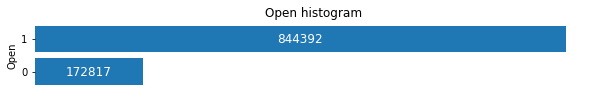

In [32]:
barh(train, 'Open')

It is a categorical feature that takes only two values: 0 and 1. So this feature is ready for training the models.

There is a significant part of zeros. For such entries the sales equal 0. So the rows where Open equals 0 can be removed.

## Sales (target)

The turnover in this day and this store. It is the numeric feature. The distribution of the feature:

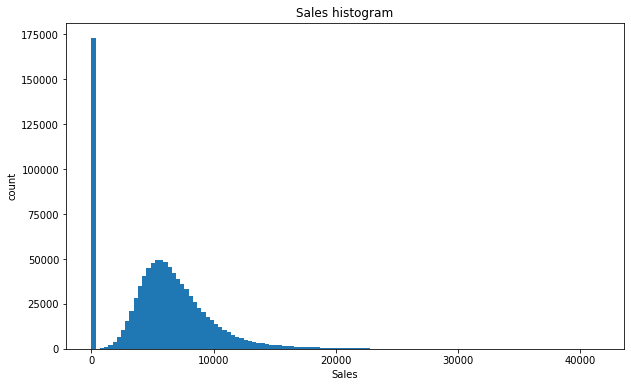

In [33]:
hist(train, 'Sales', bins=120)

It is a numeric feature. So the prediction task is the regression one.

Mind the count of zeros. It is explained by the **Open** feature: if it equals 0, then **Sales** also equals 0. The distribution of this feature when **Open** = 1:

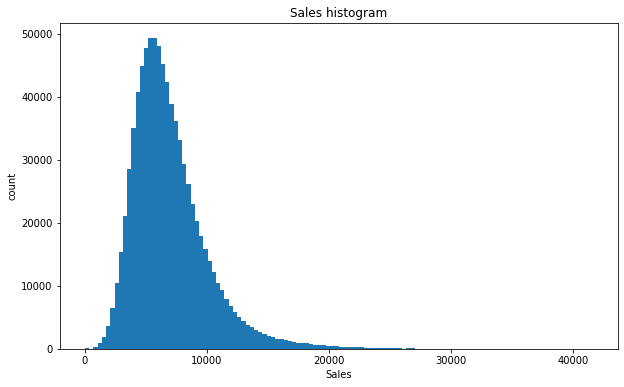

In [34]:
hist(train[train.Open == 1], 'Sales', bins=120)

As this feature is numeric and has a wide values range it should be normalized or standartized.

## Customers

The number of customers in the shop at this day. The distribution of this feature:

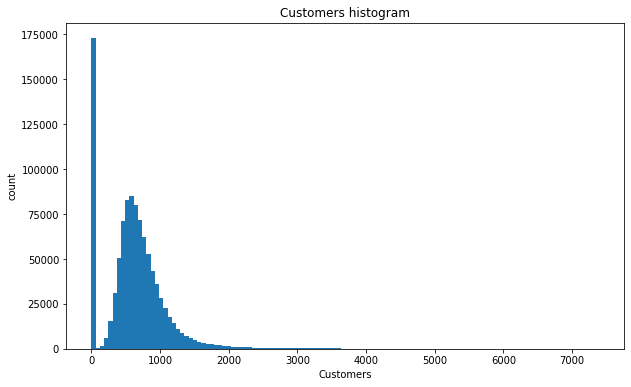

In [35]:
hist(train, 'Customers', bins=120)

It is a numeric feature.

As in the **Sales** feature there are many zeros. It is explained by the **Open** feature: if it equals 0, then the number of customers also equals 0. The distribution of this feature when **Open** = 1:

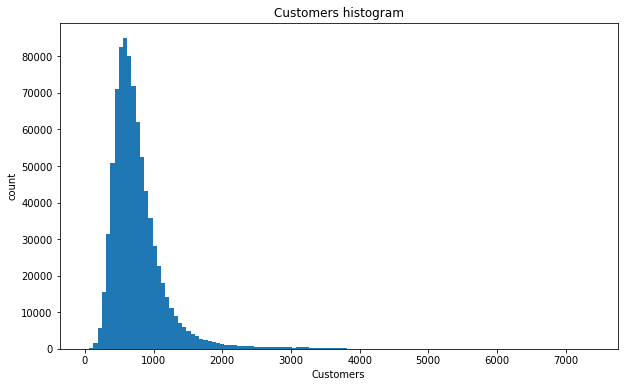

In [36]:
hist(train[train.Open == 1], 'Customers', bins=120)

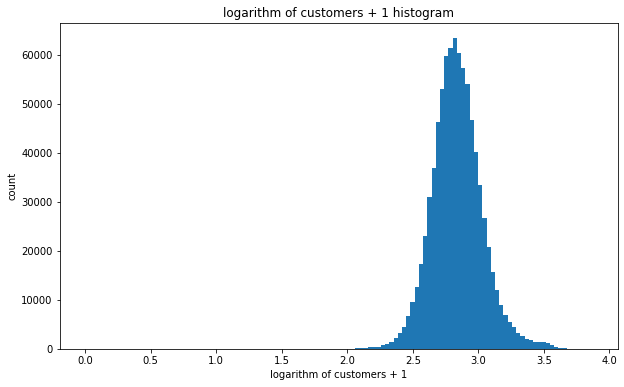

In [37]:
hist_series(np.log10(train[train.Open == 1].Customers + 1), 'logarithm of customers + 1', bins=120)

In [38]:
log_costs = np.log10(train[train.Open == 1].Customers + 1)

It is a bit similar to normal distribution.

This feature is absent in test dataset. So it will be removed when training models.

## Promo

Indicates whether a store is running a promo on that day (equals 1) or not (equals 0). The count of its values

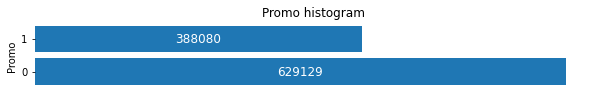

In [39]:
barh(train, 'Promo')

It is a categorical feature that takes two values: 0 and 1. So this feature is ready for training models.

## StateHoliday

Indicates a state holiday. There are four values that means: a - public holiday, b - Easter holiday, c - Christmas, 0 - no holiday. But the columns contains values 0 and '0'. So after casting the numeric values to string let's see the count of values

In [40]:
train.StateHoliday = train.StateHoliday.apply(str)

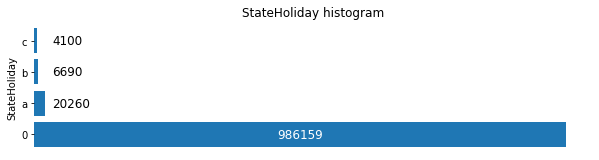

In [41]:
barh(train, 'StateHoliday')

It is a categorical feature that takes non-numeric values. So it must be transformed to numeric features e.g. using one-hot encoder.

## SchoolHoliday

Indicates if the (Store, Date) was affected by the closure of public schools. The count of values

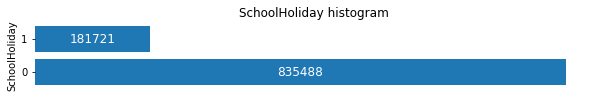

In [42]:
barh(train, 'SchoolHoliday')

## Some relations between features

Let's see in what days the stores are closed.

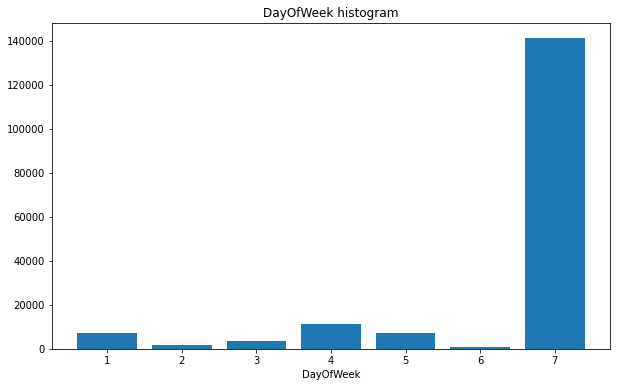

In [43]:
bar(train[train.Open == 0], 'DayOfWeek', show_count=False)

As expected the most stores have a day off as sunday. Let's see in what days the stores are opened.

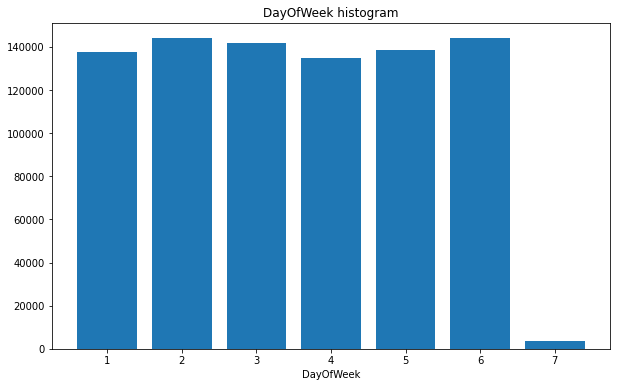

In [44]:
bar(train[train.Open == 1], 'DayOfWeek', show_count=False)

So there is almost no sundays when the stores are opened.

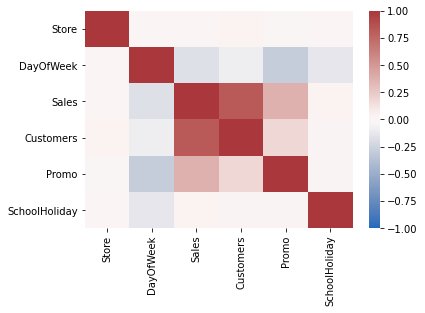

In [45]:
sns.heatmap(train[train.Open == 1].drop(columns=['Open']).corr(), cmap='vlag', vmin=-1, vmax=1)
plt.show()

In [46]:
train[train.Open == 1].drop(columns=['Open']).corr()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
Store,1.000000,0.000346,0.007710,0.033977,-0.000012,0.000512
DayOfWeek,0.000346,1.000000,-0.178736,-0.097266,-0.289265,-0.139315
Sales,0.007710,-0.178736,1.000000,0.823597,0.368145,0.038617
Customers,0.033977,-0.097266,0.823597,1.000000,0.182846,0.024902
Promo,-0.000012,-0.289265,0.368145,0.182846,1.000000,0.028964
SchoolHoliday,0.000512,-0.139315,0.038617,0.024902,0.028964,1.000000


In [47]:
weekdays = (dates - datetime.datetime(2013, 1, 1)).apply(attrgetter('days')) // 7

In [48]:
train['ordered_week'] = weekdays
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,ordered_week
0,1,5,2015-07-31,5263,555,1,1,0,1,134
1,2,5,2015-07-31,6064,625,1,1,0,1,134
2,3,5,2015-07-31,8314,821,1,1,0,1,134
3,4,5,2015-07-31,13995,1498,1,1,0,1,134
4,5,5,2015-07-31,4822,559,1,1,0,1,134


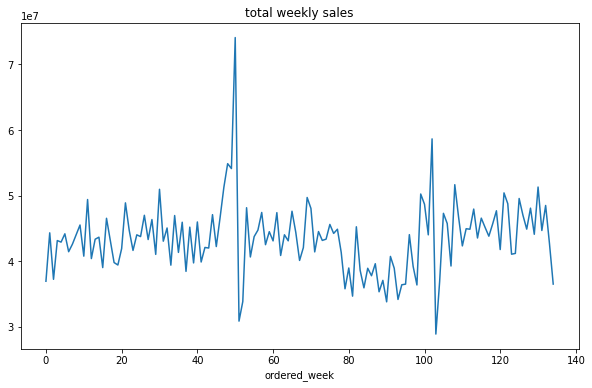

In [49]:
plt.figure(figsize=(10, 6))
train.groupby('ordered_week').agg({'Sales': 'sum'}).Sales.plot()
plt.title('total weekly sales')
plt.show()

In [50]:
dates.iloc[-1].month + 12 * (dates.iloc[-1].year - 2013) - 1

0

In [51]:
months = dates.apply(lambda date: date.month + 12 * (date.year - 2013) - 1)

In [52]:
train['ordered_month'] = months
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,ordered_week,ordered_month
0,1,5,2015-07-31,5263,555,1,1,0,1,134,30
1,2,5,2015-07-31,6064,625,1,1,0,1,134,30
2,3,5,2015-07-31,8314,821,1,1,0,1,134,30
3,4,5,2015-07-31,13995,1498,1,1,0,1,134,30
4,5,5,2015-07-31,4822,559,1,1,0,1,134,30


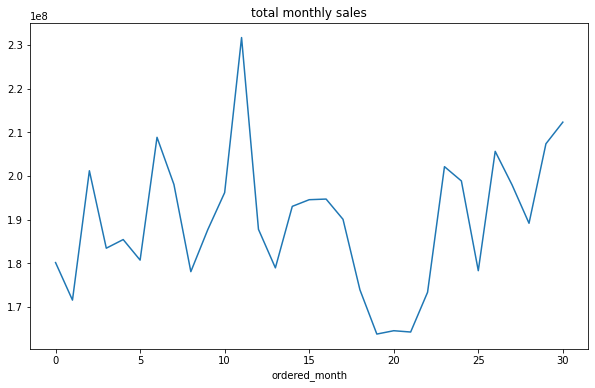

In [53]:
plt.figure(figsize=(10, 6))
train.groupby('ordered_month').agg({'Sales': 'sum'}).Sales.plot()
plt.title('total monthly sales')
plt.show()

Let's see the monthly sales depending on the **Promo** feature.

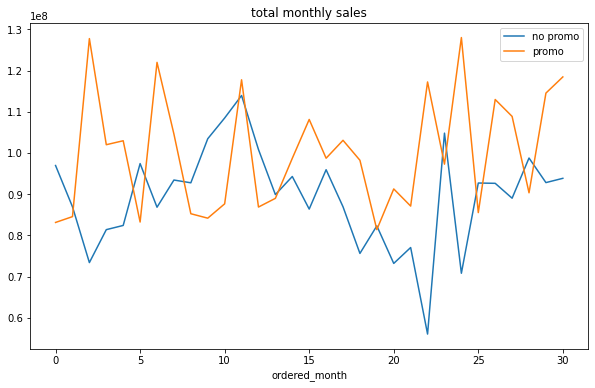

In [54]:
plt.figure(figsize=(10, 6))
train[train.Promo == 0].groupby('ordered_month').agg({'Sales': 'sum'}).Sales.plot()
train[train.Promo == 1].groupby('ordered_month').agg({'Sales': 'sum'}).Sales.plot()
plt.title('total monthly sales')
plt.legend(['no promo', 'promo'])
plt.show()

In days when there is a promo the total sales are greater. But it can be explained by the biggest count of promo days. Let's see the mean sales.

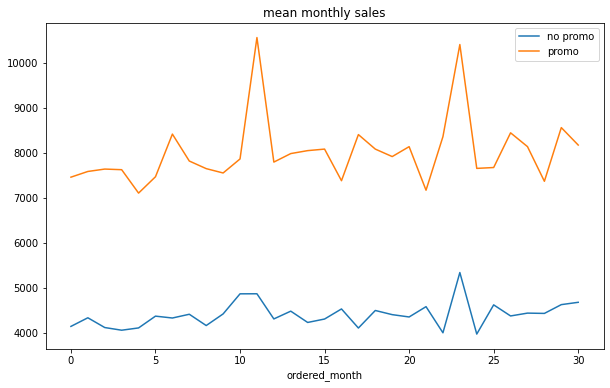

In [55]:
plt.figure(figsize=(10, 6))
train[train.Promo == 0].groupby('ordered_month').agg({'Sales': 'mean'}).Sales.plot()
train[train.Promo == 1].groupby('ordered_month').agg({'Sales': 'mean'}).Sales.plot()
plt.title('mean monthly sales')
plt.legend(['no promo', 'promo'])
plt.show()

The mean sales in promo days is higher than in usual ones. So the sales count depends on the fact if the promo is.

# test

In [56]:
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


The ***test*** table contains the same columns as the ***train*** table but the columns **Sales** and **Customers**. 

## Id

The identifier of the row used for submission

## Store

The identifier of stores. The number of stores in the table:

In [57]:
test.Store.nunique()

856

But there are 1115 different stores. So not all stores are present in test dataset.

## DayOfWeek

The day of week. The histogram of values:

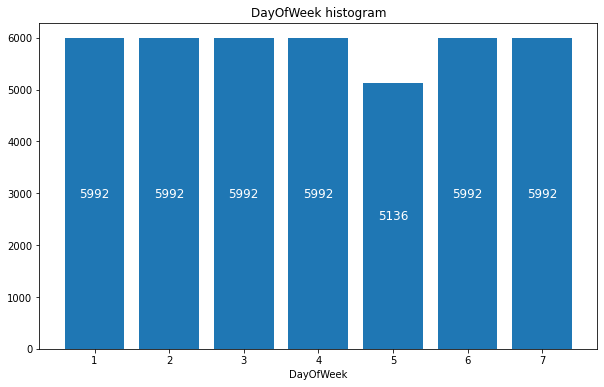

In [58]:
bar(test, 'DayOfWeek')

## Date

In [59]:
test_dates = test.Date.apply(lambda date: datetime.datetime.strptime(date, '%Y-%m-%d'))
print('The number of unique dates:', test_dates.nunique())

The number of unique dates: 48


In [60]:
print('The start date in table:', test_dates.min())
print('The end date in table:', test_dates.max())
print('The number of different days between them:', (test_dates.max() - test_dates.min()).days + 1)

The start date in table: 2015-08-01 00:00:00
The end date in table: 2015-09-17 00:00:00
The number of different days between them: 48


## Open

Let's take a look at the histogram of values:

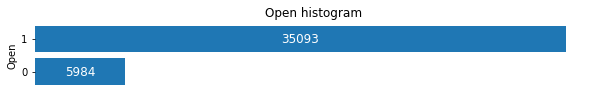

In [61]:
barh(test, 'Open')

There are rows where **Open** equals 0. For such rows the sales count also equals 0.  
Also it contains 11 missing values. Let's see what days this rows correspond.

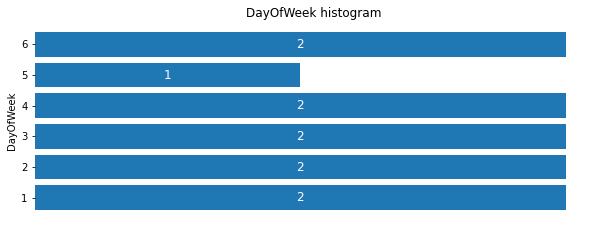

In [62]:
barh(test[test.Open.isna()], 'DayOfWeek')

There is no sundays among them. It means that with a high probability these stores were opened at these days. So the missing values will be filled with 1.

## Promo

Indicates whether a store is running a promo on that day (equals 1) or not (equals 0). The count of its values

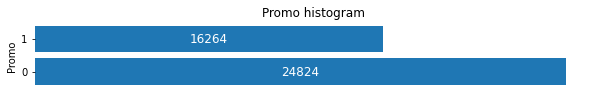

In [63]:
barh(test, 'Promo')

## StateHoliday

Indicates a state holiday. There are four values that means: a - public holiday, b - Easter holiday, c - Christmas, 0 - no holiday.

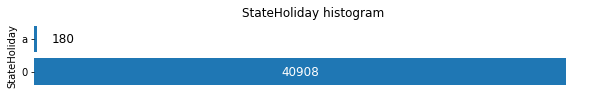

In [64]:
barh(test, 'StateHoliday')

This columns doesn't contain *'b'* and *'c'* values. It is obvious because *'b'* is Easter and *'c'* is Christmas and these holidays are not in the time range of test dataset. As value *'a'* is also a holiday the *'b'* and *'c'* values can be changed to *'a'* in train dataset.

## SchoolHoliday

Indicates if the (Store, Date) was affected by the closure of public schools. The count of values

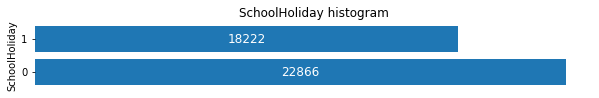

In [65]:
barh(test, 'SchoolHoliday')

The part of ones is greater than in train dataset. Probably in the time range of the test dataset there were autumn holidays.

# Problems

Я хочу как-то преобразовать данные, убрать фичу, разделить на две таблицы и т.д. Нужно ли мне делать какой-то обзор зависимостей между фичами для исходных таблиц? Ведь некоторые из них не закодированы, в некоторых мусор, а кто-то вообще лишний.

# Transformation

- ***store***
 - **StoreType** - encode using one-hot encoder
 - **Assortment** - encode using one-hot encoder
 - **CompetitionDistance** - fill nans with mean, take a logarithm and standardize
 - **CompetitionOpenSinceMonth** and **CompetitionOpenSinceYear** - combine into **the ordered number of month from January 1972** feature and normalize
 - Split the table into two ones according to the **Promo2** value - ***StorePromo0*** and ***StorePromo1***. The first table doesn't contain the promo-features. The second one contains all the promo-features but **Promo2**. **Promo2SinceWeek** and **Promo2SinceYear** are combined into **the ordered number of week since the first one of 2009** feature
- ***train***
 - **Open** - drop rows if this feature equals 0. Also drop this feature
 - **Customers** - drop it
 - **StateHoliday** - change 'b' and 'c' values to 'a' and encode it

In [66]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

## store

First of all let's encode the **StoreType** and **Assortment** features

In [176]:
store_type_values = ['a', 'b', 'c', 'd']
assortment_values = ['a', 'b', 'c']

In [177]:
encoder = OneHotEncoder([store_type_values,
                        assortment_values])

In [178]:
np.set_printoptions(edgeitems=4)

In [179]:
encoded = encoder.fit_transform(store[['StoreType', 'Assortment']]).toarray()
encoded

array([[0., 0., 1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 1.]])

In [180]:
store_type_features = [f'StoreType_{value}' for value in store_type_values]
assortment_features = [f'Assortment_{value}' for value in assortment_values]

In [181]:
store[store_type_features + assortment_features] = encoded
store = store.astype(
    dtype={value: 'int8' for value in store_type_features + assortment_features})
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,0,0,1,0,1,0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,0,0,1,0,0,0,1
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,1,0,0,0,1,0,0


In [182]:
store.drop(columns=['StoreType', 'Assortment'], inplace=True)

Then transform the **CompetitionDistance** feature: fill the missing values with mean, take a logarithm and standardize it.

In [183]:
imputer = SimpleImputer(strategy='mean')

In [184]:
imputer = SimpleImputer(strategy='mean')
store['CompetitionDistance'] = imputer.fit_transform(store[['CompetitionDistance']]).flatten()
store['LogCompetitionDistance'] = np.log10(store['CompetitionDistance'])
store.head()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,LogCompetitionDistance
0,1,1270.0,9.0,2008.0,0,NaN,NaN,NaN,0,0,1,0,1,0,0,3.103804
1,2,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,2.755875
2,3,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,4.150142
3,4,620.0,9.0,2009.0,0,NaN,NaN,NaN,0,0,1,0,0,0,1,2.792392
4,5,29910.0,4.0,2015.0,0,NaN,NaN,NaN,1,0,0,0,1,0,0,4.475816


In [185]:
scaler = StandardScaler()
store['EncodedDistance'] = scaler.fit_transform(store[['LogCompetitionDistance']]).flatten()
store.head()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,LogCompetitionDistance,EncodedDistance
0,1,1270.0,9.0,2008.0,0,NaN,NaN,NaN,0,0,1,0,1,0,0,3.103804,-0.321681
1,2,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,2.755875,-0.837582
2,3,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,4.150142,1.229804
3,4,620.0,9.0,2009.0,0,NaN,NaN,NaN,0,0,1,0,0,0,1,2.792392,-0.783436
4,5,29910.0,4.0,2015.0,0,NaN,NaN,NaN,1,0,0,0,1,0,0,4.475816,1.712706


In [186]:
store.drop(columns=['CompetitionDistance', 'LogCompetitionDistance'], inplace=True)
store.head()

,Store,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,EncodedDistance
0,1,9.0,2008.0,0,NaN,NaN,NaN,0,0,1,0,1,0,0,-0.321681
1,2,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,-0.837582
2,3,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,1.229804
3,4,9.0,2009.0,0,NaN,NaN,NaN,0,0,1,0,0,0,1,-0.783436
4,5,4.0,2015.0,0,NaN,NaN,NaN,1,0,0,0,1,0,0,1.712706


Now combine **CompetitionOpenSinceMonth** and **CompetitionOpenSinceYear** features. But first let's change outliers 1900 and 1961 to 1972.

In [187]:
ind = store[store.CompetitionOpenSinceYear.isin([1900, 1961])].index
store.loc[ind, 'CompetitionOpenSinceYear'] = 1972
store.loc[ind, 'CompetitionOpenSinceMonth'] = 3
store.loc[ind]

,Store,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,EncodedDistance
145,146,3.0,1972.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct",0,0,0,1,0,0,1,0.867493
814,815,3.0,1972.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,-0.815374


Then fill the missing values with some outlier. As the minimum year is 1972 define the outlier for year as 1900. The month will be 1.

In [188]:
store.CompetitionOpenSinceYear = store.CompetitionOpenSinceYear.fillna(1900)
store.CompetitionOpenSinceMonth = store.CompetitionOpenSinceMonth.fillna(1)
store.tail()

,Store,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,EncodedDistance
1110,1111,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,-0.062270
1111,1112,4.0,2006.0,0,NaN,NaN,NaN,0,0,1,0,0,0,1,-0.069084
1112,1113,1.0,1900.0,0,NaN,NaN,NaN,1,0,0,0,0,0,1,0.957668
1113,1114,1.0,1900.0,0,NaN,NaN,NaN,1,0,0,0,0,0,1,-0.565278
1114,1115,1.0,1900.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",0,0,0,1,0,0,1,0.604386


And now combine this features into one.

In [189]:
store['CompetitionMonthsFromStart'] = store.CompetitionOpenSinceMonth - 3 + (store.CompetitionOpenSinceYear - 1972) * 12

In [190]:
store.head()

,Store,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,EncodedDistance,CompetitionMonthsFromStart
0,1,9.0,2008.0,0,NaN,NaN,NaN,0,0,1,0,1,0,0,-0.321681,438.0
1,2,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,-0.837582,428.0
2,3,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,1.229804,417.0
3,4,9.0,2009.0,0,NaN,NaN,NaN,0,0,1,0,0,0,1,-0.783436,450.0
4,5,4.0,2015.0,0,NaN,NaN,NaN,1,0,0,0,1,0,0,1.712706,517.0


The histogram of the new feature.

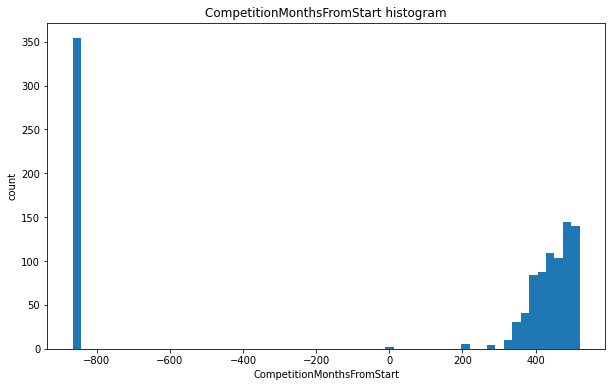

In [191]:
hist(store, 'CompetitionMonthsFromStart')

Normalize it.

In [192]:
min_max_scaler = MinMaxScaler()
store['EncodedCompetitionMonthsFromStart'] = min_max_scaler.fit_transform(store[['CompetitionMonthsFromStart']]).flatten()
store.head()

,Store,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,EncodedDistance,CompetitionMonthsFromStart,EncodedCompetitionMonthsFromStart
0,1,9.0,2008.0,0,NaN,NaN,NaN,0,0,1,0,1,0,0,-0.321681,438.0,0.940159
1,2,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,-0.837582,428.0,0.932949
2,3,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,1.229804,417.0,0.925018
3,4,9.0,2009.0,0,NaN,NaN,NaN,0,0,1,0,0,0,1,-0.783436,450.0,0.948810
4,5,4.0,2015.0,0,NaN,NaN,NaN,1,0,0,0,1,0,0,1.712706,517.0,0.997116


In [193]:
store.drop(
    columns=['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'CompetitionMonthsFromStart'],
    inplace=True)
store.head()

,Store,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,EncodedDistance,EncodedCompetitionMonthsFromStart
0,1,0,NaN,NaN,NaN,0,0,1,0,1,0,0,-0.321681,0.940159
1,2,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,-0.837582,0.932949
2,3,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,1.229804,0.925018
3,4,0,NaN,NaN,NaN,0,0,1,0,0,0,1,-0.783436,0.948810
4,5,0,NaN,NaN,NaN,1,0,0,0,1,0,0,1.712706,0.997116


Now let's combine features **Promo2SinceWeek** and **Promo2SinceYear** by the same way. Fill missing values with outliers. As the year ranges from 2009 to 2015 define the outlier for year as 1900. The "outlier" for week is 1. Also fill the missing values of **PromoInterval** feature with an empty string. It will be other category.

In [194]:
store.Promo2SinceWeek = store.Promo2SinceWeek.fillna(1)
store.Promo2SinceYear = store.Promo2SinceYear.fillna(1900)
store.PromoInterval = store.PromoInterval.fillna('')
store.head()

,Store,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,EncodedDistance,EncodedCompetitionMonthsFromStart
0,1,0,1.0,1900.0,,0,0,1,0,1,0,0,-0.321681,0.940159
1,2,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,-0.837582,0.932949
2,3,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,1.229804,0.925018
3,4,0,1.0,1900.0,,0,0,1,0,0,0,1,-0.783436,0.948810
4,5,0,1.0,1900.0,,1,0,0,0,1,0,0,1.712706,0.997116


Then calculate the ordered number of week when the store started to be participated in Promo2 assuming that a year contains 52 weeks.

In [195]:
store['Promo2WeeksFromStart'] = (store.Promo2SinceYear - 2009) * 52 + (store.Promo2SinceWeek - 1)
store.head()

,Store,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,EncodedDistance,EncodedCompetitionMonthsFromStart,Promo2WeeksFromStart
0,1,0,1.0,1900.0,,0,0,1,0,1,0,0,-0.321681,0.940159,-5668.0
1,2,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,-0.837582,0.932949,64.0
2,3,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,1.229804,0.925018,117.0
3,4,0,1.0,1900.0,,0,0,1,0,0,0,1,-0.783436,0.948810,-5668.0
4,5,0,1.0,1900.0,,1,0,0,0,1,0,0,1.712706,0.997116,-5668.0


The distribution of the new feature.

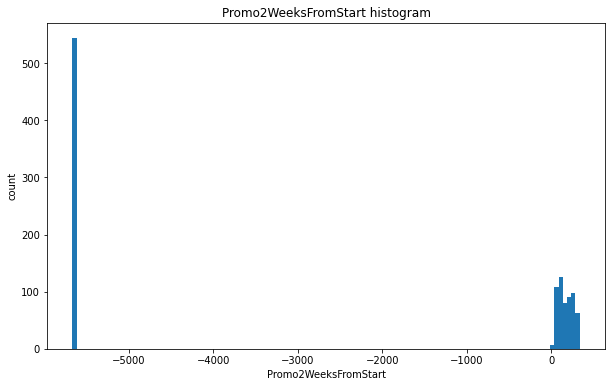

In [196]:
hist(store, 'Promo2WeeksFromStart', bins=120)

Normalize it.

In [197]:
min_max_scaler = MinMaxScaler()
store['EncodedPromo2WeeksFromStart'] = min_max_scaler.fit_transform(store[['Promo2WeeksFromStart']]).flatten()
store.head()

,Store,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,EncodedDistance,EncodedCompetitionMonthsFromStart,Promo2WeeksFromStart,EncodedPromo2WeeksFromStart
0,1,0,1.0,1900.0,,0,0,1,0,1,0,0,-0.321681,0.940159,-5668.0,0.000000
1,2,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,-0.837582,0.932949,64.0,0.955015
2,3,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,1.229804,0.925018,117.0,0.963845
3,4,0,1.0,1900.0,,0,0,1,0,0,0,1,-0.783436,0.948810,-5668.0,0.000000
4,5,0,1.0,1900.0,,1,0,0,0,1,0,0,1.712706,0.997116,-5668.0,0.000000


Finally encode the **PromoInterval** feature using one-hot encoder.

In [198]:
store.PromoInterval.unique()

array(['', 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [199]:
promo_interval_cats = ['', 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec']
encoder = OneHotEncoder(categories=[promo_interval_cats])
encoded_promo_interval_cats = [f'PromoInterval_{cat}' for cat in promo_interval_cats]
store[encoded_promo_interval_cats] = encoder.fit_transform(store[['PromoInterval']]).toarray()
store = store.astype({cat: 'int8' for cat in encoded_promo_interval_cats})
store.head()

,Store,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,EncodedDistance,EncodedCompetitionMonthsFromStart,Promo2WeeksFromStart,EncodedPromo2WeeksFromStart,PromoInterval_,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Feb,May,Aug,Nov","PromoInterval_Mar,Jun,Sept,Dec"
0,1,0,1.0,1900.0,,0,0,1,0,1,0,0,-0.321681,0.940159,-5668.0,0.000000,1,0,0,0
1,2,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,-0.837582,0.932949,64.0,0.955015,0,1,0,0
2,3,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,1.229804,0.925018,117.0,0.963845,0,1,0,0
3,4,0,1.0,1900.0,,0,0,1,0,0,0,1,-0.783436,0.948810,-5668.0,0.000000,1,0,0,0
4,5,0,1.0,1900.0,,1,0,0,0,1,0,0,1.712706,0.997116,-5668.0,0.000000,1,0,0,0


In [200]:
store.drop(columns=['Promo2SinceWeek', 'Promo2SinceYear', 'Promo2WeeksFromStart', 'PromoInterval'], inplace=True)
store.Promo2 = store.Promo2.astype('int8')
store.head()

,Store,Promo2,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,EncodedDistance,EncodedCompetitionMonthsFromStart,EncodedPromo2WeeksFromStart,PromoInterval_,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Feb,May,Aug,Nov","PromoInterval_Mar,Jun,Sept,Dec"
0,1,0,0,0,1,0,1,0,0,-0.321681,0.940159,0.000000,1,0,0,0
1,2,1,1,0,0,0,1,0,0,-0.837582,0.932949,0.955015,0,1,0,0
2,3,1,1,0,0,0,1,0,0,1.229804,0.925018,0.963845,0,1,0,0
3,4,0,0,0,1,0,0,0,1,-0.783436,0.948810,0.000000,1,0,0,0
4,5,0,1,0,0,0,1,0,0,1.712706,0.997116,0.000000,1,0,0,0


In [201]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Store                              1115 non-null   int64  
 1   Promo2                             1115 non-null   int8   
 2   StoreType_a                        1115 non-null   int8   
 3   StoreType_b                        1115 non-null   int8   
 4   StoreType_c                        1115 non-null   int8   
 5   StoreType_d                        1115 non-null   int8   
 6   Assortment_a                       1115 non-null   int8   
 7   Assortment_b                       1115 non-null   int8   
 8   Assortment_c                       1115 non-null   int8   
 9   EncodedDistance                    1115 non-null   float64
 10  EncodedCompetitionMonthsFromStart  1115 non-null   float64
 11  EncodedPromo2WeeksFromStart        1115 non-null   float

In [205]:
store.to_pickle('data/store_transformed.pickle', compression='bz2')
store.to_csv('data/store_transformed.csv', index=False)

# Load store table again